# First Model tuning an A into an Ä

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../')

In [3]:
import numpy as np
from src.data import datarenderer
import os
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.data import Dataset
import matplotlib.pyplot as plt

In [4]:
# Checking if GPU is available
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

GPU is NOT AVAILABLE


## Creating the Data

In [5]:
path = os.path.join(os.pardir, "data", "processed", "filtered-fonts")
font_file_names = os.listdir(path)
font_file_paths = [os.path.join(path, font_file_name) for font_file_name in font_file_names]
len(font_file_paths)

3769

In [6]:
datarenderer.render_font(font_file_paths[0],
                         size=64,
                         chars="AÄ").shape

(64, 64, 2)

In [7]:
charset = "AÄ"
box_size = 64
num_glyphs = len(charset)
test_size = 0.2

In [8]:
# Create a dataset from the list of paths
glyphs_array = np.array([datarenderer.render_font(font_file_path,
                                                        size=box_size,
                                                        chars=charset)
                               for font_file_path in font_file_paths])

In [9]:
# Norm the data
glyphs_array = glyphs_array / 255.0

In [62]:
print(glyphs_array.shape)
num_samples = glyphs_array.shape[0]
num_test_samples = int(num_samples * test_size)

glyphs_array_train = glyphs_array[:-num_test_samples]
glyphs_array_test = glyphs_array[-num_test_samples:]

dataset_train = Dataset.from_tensor_slices(glyphs_array_train)
dataset_test = Dataset.from_tensor_slices(glyphs_array_test)
#dataset = Dataset.from_tensor_slices(glyphs_array_train)

(3769, 64, 64, 2)


(64, 64, 2)


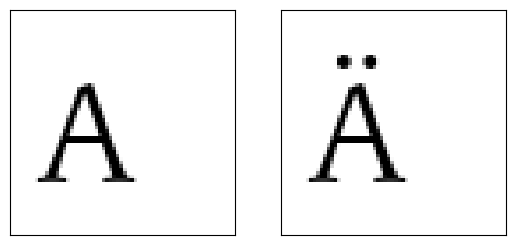

In [63]:
example = next(iter(dataset_train))
print(example.shape)

def render_charset(charset):
    fig, axs = plt.subplots(1, num_glyphs)
    for idx in range(num_glyphs):
        axs[idx].imshow(charset[:, :, idx], cmap="gray")
        axs[idx].set_xticks([])
        axs[idx].set_yticks([])
    plt.show()

render_charset(example)

In [64]:
def encode(image):
  image = tf.image.convert_image_dtype(image, dtype=tf.float32)
  return image, image

In [65]:
img1, img2 = encode(example)
print(img1.shape)
print(img2.shape)

(64, 64, 2)
(64, 64, 2)


In [66]:
dataset_train = dataset_train.map(lambda image: encode(image)).shuffle(num_samples - num_test_samples).batch(32)
dataset_test = dataset_test.map(lambda image: encode(image)).batch(32)

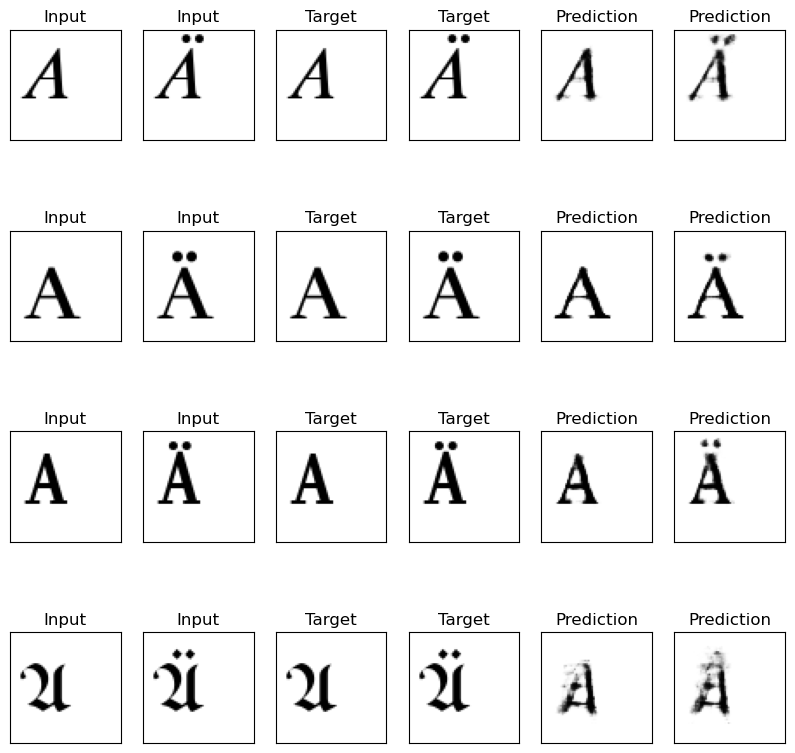

In [67]:
def render_predictions(num_pairs=4):
    # function to plot the images: input, target and prediction
    fig, axs = plt.subplots(num_pairs, 3*num_glyphs, figsize=(10, 10))
    for idx, (input_img, target_img) in enumerate(dataset_test.take(num_pairs)):
        prediction = model.predict(input_img, verbose=0)
        axs[idx, 0].imshow(input_img[0, :, :, 0], cmap="gray")
        axs[idx, 0].set_xticks([])
        axs[idx, 0].set_yticks([])
        axs[idx, 0].set_title("Input")
        axs[idx, 1].imshow(input_img[0, :, :, 1], cmap="gray")
        axs[idx, 1].set_xticks([])
        axs[idx, 1].set_yticks([])
        axs[idx, 1].set_title("Input")
        axs[idx, 2].imshow(target_img[0, :, :, 0], cmap="gray")
        axs[idx, 2].set_xticks([])
        axs[idx, 2].set_yticks([])
        axs[idx, 2].set_title("Target")
        axs[idx, 3].imshow(target_img[0, :, :, 1], cmap="gray")
        axs[idx, 3].set_xticks([])
        axs[idx, 3].set_yticks([])
        axs[idx, 3].set_title("Target")
        axs[idx, 4].imshow(prediction[0, :, :, 0], cmap="gray")
        axs[idx, 4].set_xticks([])
        axs[idx, 4].set_yticks([])
        axs[idx, 4].set_title("Prediction")
        axs[idx, 5].imshow(prediction[0, :, :, 1], cmap="gray")
        axs[idx, 5].set_xticks([])
        axs[idx, 5].set_yticks([])
        axs[idx, 5].set_title("Prediction")
    plt.show()

render_predictions()

In [68]:
class AutoEncoder(tf.keras.Model):

  def __init__(self, latent_dim, *args, **kwargs):
    assert isinstance(latent_dim, int)
    super().__init__(*args, **kwargs)
    self.latent_dim = latent_dim

    # Encoder
    self.encoder_reshape = layers.Reshape((box_size*box_size*num_glyphs,))
    self.encoder_fc1 = layers.Dense(512, activation="relu")
    self.encoder_fc2 = layers.Dense(latent_dim, activation="relu")

    # TODO: Decoder
    self.decoder_fc1 = layers.Dense(512, activation="relu")
    self.decoder_fc2 = layers.Dense(box_size*box_size*num_glyphs, activation="sigmoid")
    self.decoder_reshape = layers.Reshape((box_size, box_size, num_glyphs))

    self._build_graph()

  def _build_graph(self): # Just here because we want to see the output shapes in the summary.
    input_shape = (box_size, box_size, num_glyphs)
    self.build( (None,) + input_shape ) # (None, 28, 28, 1)
    inputs = tf.keras.Input(shape=input_shape)
    _ = self.call(inputs)

  def call(self, x):
    z = self.encode(x)
    y = self.decode(z)
    return y

  def encode(self, x):
    encoded = self.encoder_reshape(x)
    encoded = self.encoder_fc1(encoded)
    encoded = self.encoder_fc2(encoded)
    return encoded

  def decode(self, z):
    decoded = self.decoder_fc1(z)
    decoded = self.decoder_fc2(decoded)
    decoded = self.decoder_reshape(decoded)
    return decoded

model = AutoEncoder(128)

model.summary()
model.compile(
    optimizer = "adam",
    loss = "binary_crossentropy"
)

Model: "auto_encoder_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_6 (Reshape)         (None, 8192)              0         
                                                                 
 dense_12 (Dense)            (None, 512)               4194816   
                                                                 
 dense_13 (Dense)            (None, 128)               65664     
                                                                 
 dense_14 (Dense)            (None, 512)               66048     
                                                                 
 dense_15 (Dense)            (None, 8192)              4202496   
                                                                 
 reshape_7 (Reshape)         (None, 64, 64, 2)         0         
                                                                 
Total params: 8,529,024
Trainable params: 8,529,024


In [69]:
history = model.fit(
    dataset_train,
    epochs=50,
    validation_data=dataset_test
)

Epoch 1/50
95/95 [==============================] - 3s 29ms/step - loss: 0.1620 - val_loss: 0.1190
Epoch 2/50
95/95 [==============================] - 3s 27ms/step - loss: 0.1023 - val_loss: 0.1018
Epoch 3/50
95/95 [==============================] - 3s 28ms/step - loss: 0.0913 - val_loss: 0.0927
Epoch 4/50
95/95 [==============================] - 3s 27ms/step - loss: 0.0848 - val_loss: 0.0894
Epoch 5/50
95/95 [==============================] - 3s 27ms/step - loss: 0.0803 - val_loss: 0.0842
Epoch 6/50
95/95 [==============================] - 3s 27ms/step - loss: 0.0763 - val_loss: 0.0808
Epoch 7/50
95/95 [==============================] - 3s 27ms/step - loss: 0.0727 - val_loss: 0.0780
Epoch 8/50
95/95 [==============================] - 3s 27ms/step - loss: 0.0695 - val_loss: 0.0751
Epoch 9/50
95/95 [==============================] - 3s 27ms/step - loss: 0.0668 - val_loss: 0.0770
Epoch 10/50
95/95 [==============================] - 3s 28ms/step - loss: 0.0648 - val_loss: 0.0725
Epoch 11/

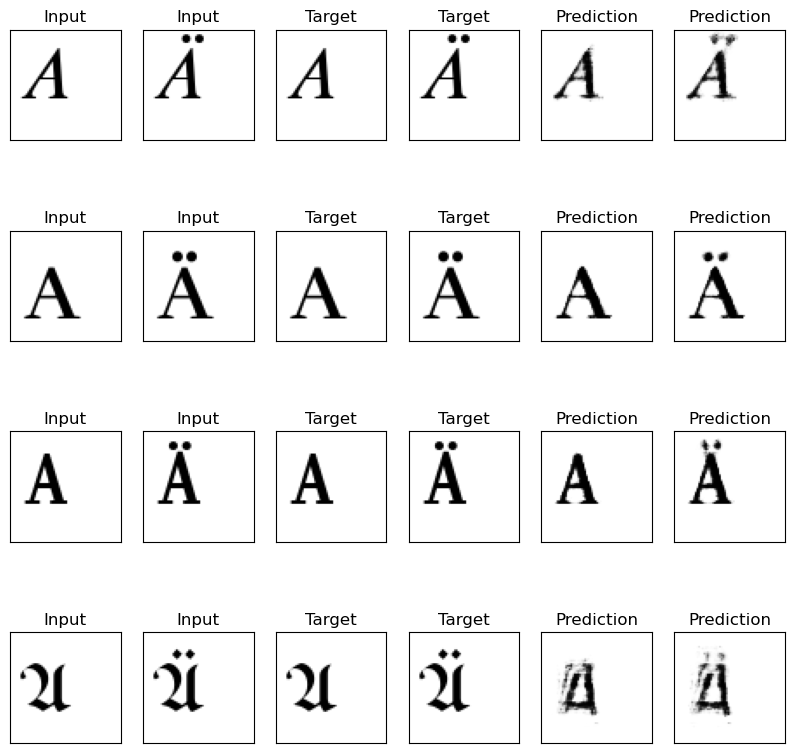

In [70]:
render_predictions()

In [71]:
# freeze the decoder layers
model.decoder_fc1.trainable = False
model.decoder_fc2.trainable = False

In [72]:
# overwriting the function encode, such that the second layer is completely 1
#def encode(image):
#  image = tf.image.convert_image_dtype(image, dtype=tf.float32)
#  return image, image
def encode(image):
  image = tf.image.convert_image_dtype(image, dtype=tf.float32)
  image1 = image[:, :, 0]
  image2 = image[:, :, 1]
  image1 = tf.expand_dims(image1, -1)
  image2 = tf.expand_dims(image2, -1)
  image2 = tf.ones_like(image2)
  image_input = tf.concat([image1, image2], axis=-1)
  return image_input, image

In [73]:
glyphs_array_train = glyphs_array[:-num_test_samples]
glyphs_array_test = glyphs_array[-num_test_samples:]

dataset_train = Dataset.from_tensor_slices(glyphs_array_train)
dataset_test = Dataset.from_tensor_slices(glyphs_array_test)

dataset_train = dataset_train.map(lambda image: encode(image)).shuffle(num_samples - num_test_samples).batch(32)
dataset_test = dataset_test.map(lambda image: encode(image)).batch(32)

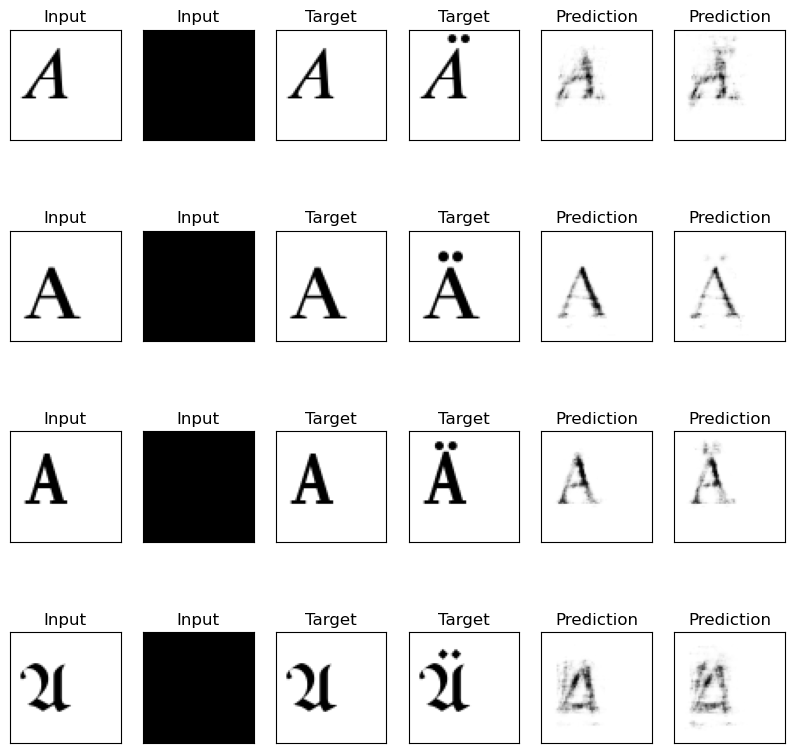

In [74]:
render_predictions()

In [75]:
# Training the model with the frozen decoder layers, to predict the Ä
history = model.fit(
    dataset_train,
    epochs=20,
    validation_data=dataset_test
)

Epoch 1/20
95/95 [==============================] - 3s 27ms/step - loss: 0.0786 - val_loss: 0.0782
Epoch 2/20
95/95 [==============================] - 3s 27ms/step - loss: 0.0569 - val_loss: 0.0737
Epoch 3/20
95/95 [==============================] - 3s 27ms/step - loss: 0.0518 - val_loss: 0.0720
Epoch 4/20
95/95 [==============================] - 3s 27ms/step - loss: 0.0487 - val_loss: 0.0753
Epoch 5/20
95/95 [==============================] - 3s 28ms/step - loss: 0.0483 - val_loss: 0.0755
Epoch 6/20
95/95 [==============================] - 3s 28ms/step - loss: 0.0467 - val_loss: 0.0715
Epoch 7/20
95/95 [==============================] - 3s 27ms/step - loss: 0.0456 - val_loss: 0.0746
Epoch 8/20
95/95 [==============================] - 3s 28ms/step - loss: 0.0442 - val_loss: 0.0721
Epoch 9/20
95/95 [==============================] - 3s 28ms/step - loss: 0.0435 - val_loss: 0.0721
Epoch 10/20
95/95 [==============================] - 3s 28ms/step - loss: 0.0433 - val_loss: 0.0712
Epoch 11/

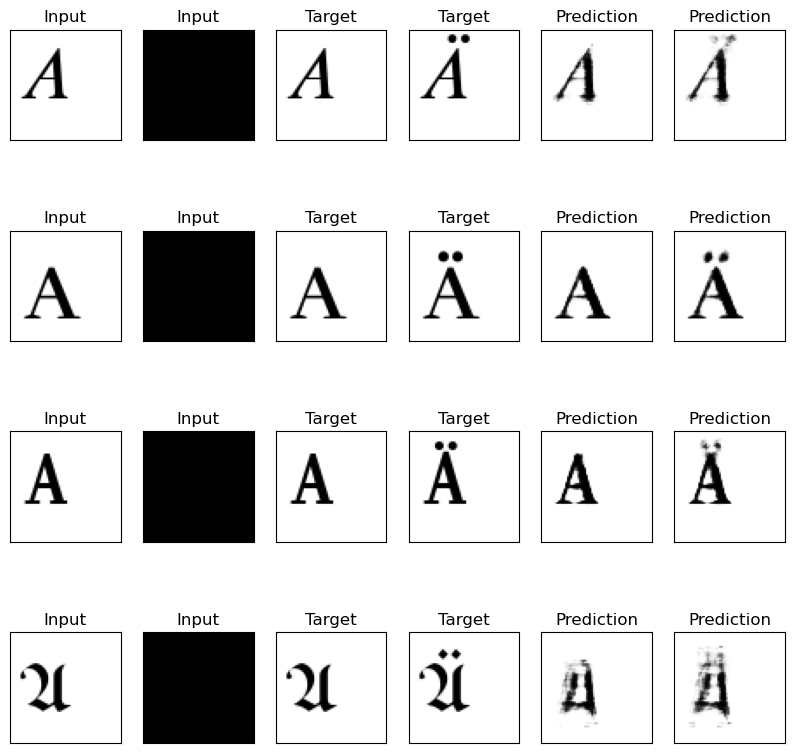

In [76]:
render_predictions()